# **Libraries.**


In [10]:
'''
    Import related libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as const
import scipy.special
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad
from sklearn.metrics import mean_squared_error

from google.colab import files
from IPython.display import Markdown, display
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LinearLocator, FuncFormatter, LogLocator
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# **Import files.**


In [ ]:

uploaded = files.upload(); # Upload command
choosefiles = list(uploaded.keys()); # Choose files

'''
   Store and read data frames'''
# Empty lists to store dataframes and file names//
dfs = []; # To store dataframes from uploaded files.
file_names = []; # To store file names.

# Load all uploaded files and their data//
for file_name in choosefiles:
    xls = pd.ExcelFile(file_name); # Open Excel file and inspect its contents.
    df = pd.read_excel(file_name, sheet_name=xls.sheet_names[0]); # Read sheet into a pandas dataframe.
    dfs.append(df); # Store the dataframe.
    file_names.append(file_name); # Store the file names.

    # Print the first few rows of each file//
    print(f"First few lines of {file_name}:");
    print(df.head()); # Display the first 5 rows of the dataframe.
    print("\n" + "="*50 + "\n"); # Separator for clarity.


Saving x = 0 mm.xlsx to x = 0 mm.xlsx
Saving x = 7.79475 mm.xlsx to x = 7.79475 mm.xlsx
Saving x = 12.86946 mm.xlsx to x = 12.86946 mm.xlsx
Saving x = 17.90498 mm.xlsx to x = 17.90498 mm.xlsx
Saving x = 23.07683 mm.xlsx to x = 23.07683 mm.xlsx
Saving x = 27.48345 mm.xlsx to x = 27.48345 mm.xlsx
Saving x = 32.9586 mm.xlsx to x = 32.9586 mm.xlsx
Saving x = 37.681 mm.xlsx to x = 37.681 mm.xlsx
Saving x = 42.79084 mm.xlsx to x = 42.79084 mm.xlsx
Saving x = 47.84624 mm.xlsx to x = 47.84624 mm.xlsx
Saving x = 52.68388 mm.xlsx to x = 52.68388 mm.xlsx
Saving x = 57.00472 mm.xlsx to x = 57.00472 mm.xlsx
First few lines of x = 0 mm.xlsx:
                     Unnamed: 0        Unnamed: 1  Unnamed: 2  Unnamed: 3  \
0  Temperatures, d = 0.00000 mm               NaN         NaN         NaN   
1                           NaN  T (K) at t (min)         NaN         NaN   
2                         P (W)                 1    2.000000    3.000000   
3                           0.1        294.436555  294.6

# **Processing data files.**


In [ ]:
'''
   Extract T_ov, x, P_dc and t_oh values'''

data_list = [];

for df, file_name in zip(dfs, file_names):
    x_value = float(file_name.split('=')[1].split(' ')[1]); # Extract x value from file name
    df_clean = df.iloc[3:].dropna(axis=1, how='all'); # Skip header rows and remove empty columns
    df_clean.columns = ['P'] + list(range(1, len(df_clean.columns))); # Rename columns
    for row in df_clean.itertuples(index=False):
        P = row[0]; # First column as Power
        for t, T in enumerate(row[1:], start=1): # Remaining columns as temperature over time
            if not np.isnan(T): # Ignore NaN values
                data_list.append([x_value, P, t, T]);

'''
   Convert the list to a DataFrame'''
data = pd.DataFrame(data_list, columns=['x', 'P', 't', 'T']);
print(data);


             x     P   t           T
0      0.00000   0.1   1  294.436555
1      0.00000   0.1   2  294.646516
2      0.00000   0.1   3  294.805052
3      0.00000   0.1   4  294.940510
4      0.00000   0.1   5  295.056907
...        ...   ...  ..         ...
3055  57.00472  24.0  11  299.463214
3056  57.00472  24.0  12  300.295406
3057  57.00472  24.0  13  301.117791
3058  57.00472  24.0  14  301.919831
3059  57.00472  24.0  15  302.710251

[3060 rows x 4 columns]


# **Neural network implementation.**

# **1. Training & testing.**

In [ ]:
'''
   Splitting, scaling, training and testing for the model'''
# Split data into features and target//
X = data[['x', 'P', 't']].values;
y = data['T'].values;

# Scale data for neural network//
scaler_X = MinMaxScaler(); scaler_y = MinMaxScaler();
X_scaled = scaler_X.fit_transform(X); y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten();

# Split into training and testing datasets//
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42);

# Train the neural network model//
nn_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42);
nn_model.fit(X_train, y_train);

# Evaluate model//
train_score = nn_model.score(X_train, y_train);
print(f"Training Score (R^2): {train_score:.4f}");

test_score = nn_model.score(X_test, y_test);
print(f"Testing Score (R^2): {test_score:.4f}");


Training Score (R^2): 0.9882
Testing Score (R^2): 0.9891


# **2. Network weights and biases.**

In [ ]:
'''
   For evaluation: weights and biases'''
weights = nn_model.coefs_; # Weights.
biases = nn_model.intercepts_; # Biases.

'''
   For evaluation: number of neurons in each layer (input layer, hidden layers, and output layer)'''
num_neurons = [X_train.shape[1]] + list(nn_model.hidden_layer_sizes) + [1]; # Input layer, hidden layers, output layer.

# Display weights, biases, and number of neurons for each layer//
for i, (w, b) in enumerate(zip(weights, biases)):
    print(f"Layer {i + 1}:");
    print(f"  Number of neurons: {num_neurons[i]} -> {num_neurons[i + 1]}");
    print(f"  Weights shape: {w.shape}");
    print(f"  Biases shape: {b.shape}");

    print(f"  Weights (first 5 elements):\n{w[:5]}..."); # Display 5 weight elements.
    print(f"  Biases (first 5 elements):\n{b[:5]}...\n"); # Display 5 biases elements.

'''
   For defining activation function'''
def relu(x):
    return np.maximum(0, x); # Rectified linear unit (ReLU) activation#

def neural_network_approx(x, P, t):

    inputs = np.array([x, P, t]).reshape(1, -1); # Combine inputs.
    inputs_scaled = scaler_X.transform(inputs); # Scale inputs.

    # 1st hidden layer//
    hidden_layer_1 = relu(np.dot(inputs_scaled, weights[0]) + biases[0]);

    # 2nd hidden layer//
    hidden_layer_2 = relu(np.dot(hidden_layer_1, weights[1]) + biases[1]);

    # Output layer//
    output = (np.dot(hidden_layer_2, weights[2]) + biases[2]);

    # Scale output back to original temperature values//
    temperature = scaler_y.inverse_transform(output.reshape(-1, 1)).flatten();
    return temperature[0]; # Return the scalar temperature value.

'''
   Example to approximate temperature for a specific input'''
x_sample, P_sample, t_sample = 32.9586, 5.4, 15;
predicted_T = neural_network_approx(x_sample, P_sample, t_sample);
print(f"Approximated temperature for (x={x_sample}, P={P_sample}, t={t_sample}): T = {predicted_T:.2f} K");


Layer 1:
  Number of neurons: 3 -> 50
  Weights shape: (3, 50)
  Biases shape: (50,)
  Weights (first 5 elements):
[[-1.40337040e-01  3.46014754e-01  3.18453465e-01  2.62621471e-02
  -2.24187221e-01 -5.10065621e-01 -3.40978274e-01  4.15853285e-01
   1.44463008e-03  1.79869442e-01 -1.29896240e-01  3.44594829e-01
   2.96011979e-01 -3.96455172e-01 -5.35953096e-02 -2.99259631e-01
  -1.34044453e-01  6.86149954e-03 -3.05168820e-04 -1.11086642e-01
  -1.40714259e-02 -7.16215720e-02 -1.71088280e-02 -1.62173026e-02
  -1.11349510e-01  2.20616184e-01 -1.69242971e-01 -3.36186142e-03
  -7.16279623e-03 -1.16459409e-01  1.42067148e-02 -5.82301975e-02
  -3.00111272e-01  3.70410527e-01  4.56081597e-01  2.92384313e-01
  -2.93407876e-01 -4.03004687e-01 -8.23159015e-03 -1.64822070e-01
  -2.46670736e-01  3.94986555e-02 -2.63599299e-01  3.64548714e-01
  -4.49948502e-01  9.84498937e-02 -2.32884832e-01  1.49224411e-02
   1.00882706e-01 -2.70773305e-01]
 [ 3.43195564e-01  1.89917816e-01  3.60495556e-01  2.85952

# **Plot.**

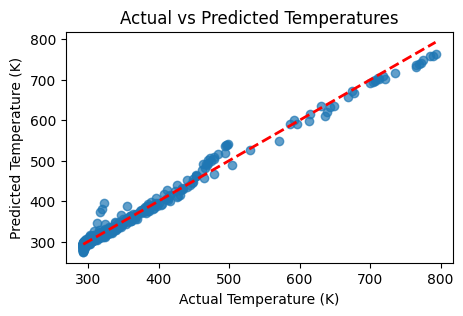

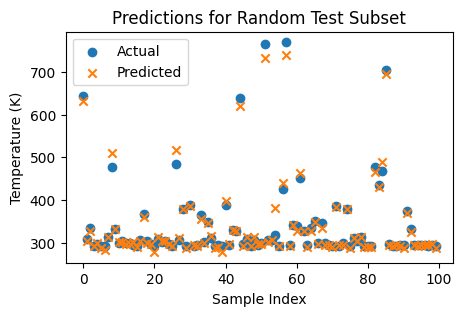

In [ ]:
'''
   Predict using the neural network for testing data'''
y_pred_scaled = nn_model.predict(X_test);

'''
   Inverse transform to get actual values'''
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten();
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten();

# Scatter plot of actual vs predicted temperatures//
plt.figure(figsize=(5, 3))
plt.scatter(y_actual, y_pred, alpha=0.7);
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2);
plt.title("Actual vs Predicted Temperatures");
plt.xlabel("Actual Temperature (K)");
plt.ylabel("Predicted Temperature (K)");
plt.grid(False);
plt.show();

# Visualize predictions for x, P, t combinations in a subset of test data
subset_indices = np.random.choice(len(X_test), size=100, replace=False)  # Select 100 random samples for visualization
X_subset = X_test[subset_indices]
y_actual_subset = y_actual[subset_indices]
y_pred_subset = y_pred[subset_indices]

plt.figure(figsize=(5,3))
plt.scatter(range(len(subset_indices)), y_actual_subset, label="Actual", marker="o");
plt.scatter(range(len(subset_indices)), y_pred_subset, label="Predicted", marker="x");
plt.title("Predictions for Random Test Subset");
plt.xlabel("Sample Index");
plt.ylabel("Temperature (K)");
plt.legend();
plt.grid(False);
plt.show();
